In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.linalg as linalgx
import os
import time
from lib.ParticleFilter import sample_normal_model, single_step_particle_filter, normal_model_pdf, single_step_particle_filter_measurement_window
from utils.plotting import draw_ellipse, images_to_gif
from utils.filesTools import get_exp_folder
from utils.notionConnector import add_experiment_to_notion
from pathlib import Path
import scipy.stats as stats

import json

In [9]:
NUM_OF_BEACONS = 2
NUM_OF_AGENTS = 1
STATE_SIZE_2D = 2
SINGLE_RANGE_MEASUREMENT_SIZE = 1
RANGE_MEASUREMENT_SIZE = NUM_OF_BEACONS * SINGLE_RANGE_MEASUREMENT_SIZE * NUM_OF_AGENTS
TOTAL_STATE_SIZE = NUM_OF_AGENTS * STATE_SIZE_2D + NUM_OF_BEACONS * STATE_SIZE_2D
sigma_transition_agent = 0.5
sigma_transition_beacon = 0.3
sigma_measurement = 0.1
stepsize = 2
n_steps = 50
n_particles = 100
# model definition
cov_measurement = np.diag([sigma_measurement**2 for i in range(RANGE_MEASUREMENT_SIZE)])
cov_transition_agent = [sigma_transition_agent**2 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
# cov_transition_agent = [0 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_beacon = [sigma_transition_beacon**2 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon = [0 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon[0:6] = [sigma_transition_beacon**2]*6
cov_transition = np.diag(cov_transition_agent + cov_transition_beacon)
get_agent_index = lambda i: slice(i*STATE_SIZE_2D, i*STATE_SIZE_2D + STATE_SIZE_2D)
get_beacon_index = lambda i: slice(STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D, STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D + STATE_SIZE_2D)
get_agent_position = lambda x, i: x[get_agent_index(i)]
get_beacon_postion = lambda x, j: x[get_beacon_index(j)]
def state_to_agent_and_beacons_pos(x):
    agents_pos = np.zeros((NUM_OF_AGENTS, STATE_SIZE_2D))
    beacons_pos = np.zeros((NUM_OF_BEACONS, STATE_SIZE_2D))
    for i in range(NUM_OF_AGENTS):
        agents_pos[i] = get_agent_position(x, i)
    for j in range(NUM_OF_BEACONS):
        beacons_pos[j] = get_beacon_postion(x, j)
    return agents_pos, beacons_pos
def agent_and_beacons_pos_to_state(agents_pos, beacons_pos):
    x = np.zeros(TOTAL_STATE_SIZE)
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)] = agents_pos[i]
    for j in range(NUM_OF_BEACONS):
        x[get_beacon_index(j)] = beacons_pos[j]
    return x


def calculate_true_range_meas(x):
    """
    Function to calculate the true range measurements.
    It calculates the Euclidean distance between each agent and each beacon.
    """
    z = np.zeros(RANGE_MEASUREMENT_SIZE)
    for i in range(NUM_OF_AGENTS):
        current_agent_position = x[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            current_beacon_position = x[get_beacon_index(j)]
            z[i*NUM_OF_BEACONS + j] = np.linalg.norm(current_agent_position - current_beacon_position)
    return z

def measurements_model(x, cov = cov_measurement):
    '''
    Function to generate the range measurements model.
    It adds a normally distributed noise to the true range measurements.
    '''
    return calculate_true_range_meas(x) + sample_normal_model(np.zeros(RANGE_MEASUREMENT_SIZE), cov)

'''
function to calculates the likelihood of the measurements given the state.
It uses a normal probability density function with the true range measurements
as the mean and the measurement covariance as the covariance
'''
measurements_likelihood = lambda z, x: normal_model_pdf(z, calculate_true_range_meas(x), cov_measurement)

[0.11875693 0.11875693]
[0.70710678 0.70710678]


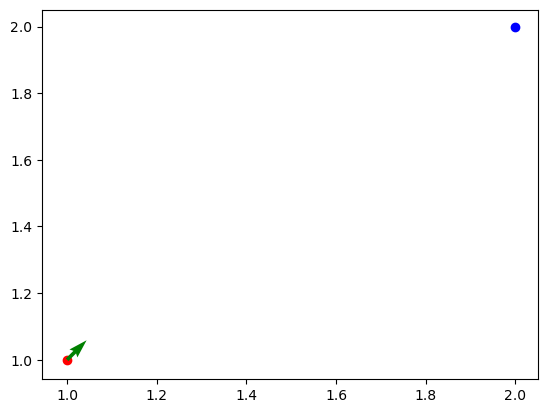

In [3]:
def calculate_gradient(x_i, z_i, normalize = True):
    #check if x is a pandas series
    # the gradient is calculated with respect to the state vector x,
    # the furmula is dL/dx = -0.5 * L(x) * dL/dz * dz/dx
    # Where L(x) is the likelihood of the measurements given the state x
    # dL/dz is the gradient of the likelihood with respect to the measurements
    # dz/dx is the gradient of the measurements with respect to the state
    if type(x_i) == pd.Series:
        x_i = x_i.values
    dzest_dx = np.zeros((RANGE_MEASUREMENT_SIZE, TOTAL_STATE_SIZE))
    for i in range(NUM_OF_AGENTS):
        agent_pos = x_i[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            beacon_pos = x_i[get_beacon_index(j)]
            z_est = np.linalg.norm(agent_pos - beacon_pos)
            dx = agent_pos - beacon_pos
            dzest_dx[i*NUM_OF_BEACONS + j, get_agent_index(i)] =   dx/z_est
            dzest_dx[i*NUM_OF_BEACONS + j, get_beacon_index(j)] = -dx/z_est

    dLdz = np.zeros((1, RANGE_MEASUREMENT_SIZE))
    inv_cov = np.linalg.inv(cov_measurement)
    dz = z_i - calculate_true_range_meas(x_i)
    dLdz = -2 * dz @ inv_cov

    L_of_x = measurements_likelihood(z_i, x_i)
    normlized_dLdX = dLdz @ dzest_dx # this will be normalized later, just initilize it here without common factors
    dLdx = -0.5 * L_of_x * normlized_dLdX
    # dLdx = normlized_dLdX.copy()

    
    # normalize the gradient in pairs of 2
    if normalize: 
        # normlized_dLdX = np.zeros(TOTAL_STATE_SIZE) # we dont not need to create a new array, we can use the same one
        for i in range(NUM_OF_AGENTS):
            norm = np.linalg.norm(dLdx[get_agent_index(i)])
            normlized_dLdX[get_agent_index(i)] = dLdx[get_agent_index(i)]/norm
        for j in range(NUM_OF_BEACONS):
            norm = np.linalg.norm(dLdx[get_beacon_index(j)])
            normlized_dLdX[get_beacon_index(j)] = dLdx[get_beacon_index(j)]/norm

    return dLdx, normlized_dLdX

#function to calculate the gradient of the likelihood for only one agent and one beacon
def calculate_gradient_single_agent_beacon(agent_pos, beacon_pos,z_i):
    MEAS_SIZE_2D = 1
    STATE_SIZE_2D = 2
    z_est = np.linalg.norm(agent_pos - beacon_pos)
    dx = agent_pos - beacon_pos
    dzest_dx = np.zeros((1, STATE_SIZE_2D))
    dzest_dx[0:STATE_SIZE_2D] = dx/z_est

    dLdz = np.zeros((1, 1))
    inv_cov = np.array([1/sigma_measurement])
    dz = np.array([z_i - z_est])
    dLdz = -2 * dz * inv_cov
    L_of_x = normal_model_pdf(z_i, z_est, sigma_measurement**2)
    normlized_dLdX = dLdz @ dzest_dx
    dLdx = -0.5 * L_of_x * normlized_dLdX
    normlized_dLdX = dLdx / np.linalg.norm(dLdx)
    return dLdx, normlized_dLdX

#test the single agent and beacon gradient function
agent_pos = np.array([1, 1])
beacon_pos = np.array([2, 2])
z_i = 1.41
dLdx, normlized_dLdX = calculate_gradient_single_agent_beacon(agent_pos, beacon_pos,z_i)
print(dLdx)
print(normlized_dLdX)

#plot the results od the test with arrow showing the gradient
plt.figure()
plt.scatter(agent_pos[0], agent_pos[1], color='r', label='agent')
plt.scatter(beacon_pos[0], beacon_pos[1], color='b', label='beacon')
plt.quiver(agent_pos[0], agent_pos[1], normlized_dLdX[0], normlized_dLdX[1], color='g', label='gradient')

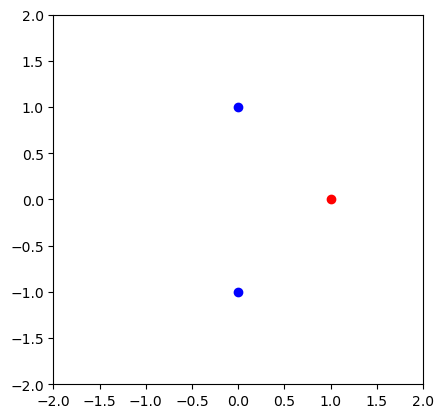

In [29]:
agent_pos_0  = np.array([1, 0])
beacon0_pos_0 = np.array([0, 1])
beacon1_pos_0 = np.array([0, -1])
#plot positions
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

ax.plot(agent_pos_0[0], agent_pos_0[1], 'ro')
ax.plot(beacon0_pos_0[0], beacon0_pos_0[1], 'bo')
ax.plot(beacon1_pos_0[0], beacon1_pos_0[1], 'bo')


[ 1.  0.  0.  1.  0. -1.]
7.977536792483193
7.8870593617814055
7.796828429260169
7.706859162233856
7.617166475712374
7.5277650293204355
7.438669224380938
7.349893201161932
7.261450836287218
7.173355740310086
7.085621255449836
6.998260453490144
6.911286133839305
6.824710821750745
6.738546766703404
6.652805940940966
6.567500038168698
6.48264047240665
6.398238376998054
6.314304603771773
6.230849722356638
6.14788401964681
6.065417499416217
5.983459882080246
5.902020604603133
5.821108820548797
5.740733400273594
5.6609029312585735
5.58162571857919
5.50290978551063
5.424762874265885
5.347192446864836
5.270205686131728
5.193809496818523
5.118010506851839
5.042815068700786
4.968229260863314
4.894258889468108
4.820909489989735
4.748186329074082
4.676094406471392
4.604638457074203
4.533822953057122
4.4636521061160055
4.394129869803221
4.325259941956392
4.257045767217667
4.189490539640253
4.122597205379925
4.056368465467884
3.990806778662192
3.9259143643751844
3.8616932056731246
3.7981450523458817

/tmp/ipykernel_21193/1270691856.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.5, 1.0, 'likelihood of the measurements given the state')

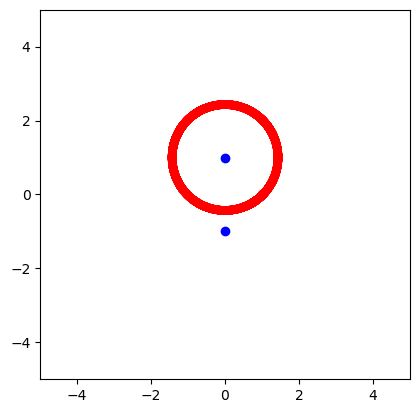

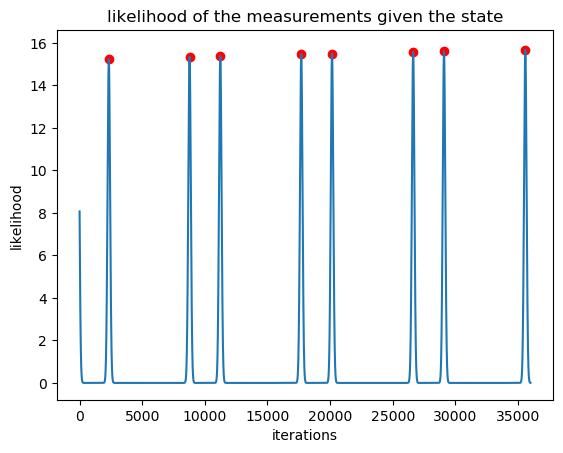

In [30]:
#initial state
x_0 = agent_and_beacons_pos_to_state([agent_pos_0], [beacon0_pos_0, beacon1_pos_0])
print(x_0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')

ax.plot(agent_pos_0[0], agent_pos_0[1], 'ro')
ax.plot(beacon0_pos_0[0], beacon0_pos_0[1], 'bo')
ax.plot(beacon1_pos_0[0], beacon1_pos_0[1], 'bo')
#plot the direction of the gradient
a = get_agent_position(x_0, 1)
x = x_0
stepsize = 0.001
prev_move_dir = None
z = measurements_model(x)
measurements_likelihood_log = [measurements_likelihood(z, x)]
for i in range(2*18000):
    dLdx, normlized_dLdX = calculate_gradient_single_agent_beacon(x[get_agent_index(0)],x[get_beacon_index(0)], z[0])
    move_dir = np.array([normlized_dLdX[1], -normlized_dLdX[0]])
    if prev_move_dir is not None and np.dot(prev_move_dir, move_dir) < 0:
        move_dir *= -1
    ax.quiver(x[get_agent_index(0)][0], x[get_agent_index(0)][1], move_dir[0], move_dir[1], color='r')
    x[get_agent_index(0)] += stepsize * move_dir
    print(measurements_likelihood(z, x))
    measurements_likelihood_log.append(measurements_likelihood(z, x))
    prev_move_dir = move_dir
fig.show()
measurements_likelihood_log = np.array(measurements_likelihood_log)
## find all local maxima
maxima = []
for i in range(1, len(measurements_likelihood_log)-1):
    if measurements_likelihood_log[i] > measurements_likelihood_log[i-1] and measurements_likelihood_log[i] > measurements_likelihood_log[i+1]:
        maxima.append(i)

maxima = np.array(maxima)
#plot the likelihood of the measurements given the state
plt.figure()
plt.plot(measurements_likelihood_log)
plt.scatter(maxima, measurements_likelihood_log[maxima], color='r')

plt.xlabel('iterations')
plt.ylabel('likelihood')
plt.title('likelihood of the measurements given the state')

In [ ]:
x_0 = agent_and_beacons_pos_to_state([agent_pos_0], [beacon0_pos_0, beacon1_pos_0])
print(x_0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

ax.plot(agent_pos_0[0], agent_pos_0[1], 'ro')
ax.plot(beacon0_pos_0[0], beacon0_pos_0[1], 'bo')
ax.plot(beacon1_pos_0[0], beacon1_pos_0[1], 'bo')
#plot the direction of the gradient
dLdx, normlized_dLdX = calculate_gradient(x_0, measurements_model(x_0))
a = get_agent_position(x_0, 1)
x = x_0
stepsize = 0.001
for i in range(100):
    dLdx, normlized_dLdX = calculate_gradient(x, measurements_model(x))
    ax.quiver(x[get_agent_index(0)][0], x[get_agent_index(0)][1], normlized_dLdX[get_agent_index(0)][1], -normlized_dLdX[get_agent_index(0)][0], color='r')
    x[get_agent_index(0)] += stepsize * np.array([normlized_dLdX[get_agent_index(0)][1], -normlized_dLdX[get_agent_index(0)][0]])
fig.show()

In [ ]:
class GradientResamplingUtiles():
    @staticmethod
    def single_measerment_gradient_calculation(agent_positon, beacon_position, measurement, sigma_measurement = 0.1, step_size = 0.1, number_of_step = 100): 
        _MEAS_SIZE_2D = 1
        _STATE_SIZE_2D = 2
        a = agent_positon
        b = beacon_position
        z = measurement
        s = sigma_measurement
        
        dx = a - b
        z_est = np.linalg.norm(dx)
        dzest_dx = np.zeros((1, _STATE_SIZE_2D))
        dzest_dx[0:_MEAS_SIZE_2D] = dx/z_est
        dLdz = np.zeros((1, 1))
        inv_cov = np.array([1/s])
        dz = np.array([z - z_est])
        dLdz = -2 * dz * inv_cov
        L_of_x = normal_model_pdf(z, z_est, s**2)
        dLdx = -0.5 * L_of_x * dLdz @ dzest_dx
        normlized_dLdX = dLdx / np.linalg.norm(dLdx)
        return dLdx, normlized_dLdX
    
    @staticmethod
    def start_travel_along_gradient(x, z, agent_id, beacon_id, sigma_measurement = 0.1, step_size = 0.1, number_of_step = 100, do_debug = False):
        agent_positon = x[get_agent_index(agent_id)]
        beacon_position = x[get_beacon_index(beacon_id)]
        agent_beacon_measerment = z[agent_id*NUM_OF_BEACONS + beacon_id]
        current_position = agent_positon
        prev_move_direction = None
        agent_position_log = np.zeros((number_of_step, 2))
        measurements_likelihood_log = np.zeros(number_of_step)
        if do_debug
            move_direction_log = np.zeros((number_of_step, 2))
        for i in range(number_of_step):
            _, grad_normlized = GradientResamplingUtiles.single_measerment_gradient_calculation(current_position,
                                                                                                beacon_position,
                                                                                                agent_beacon_measerment,
                                                                                                sigma_measurement,
                                                                                                step_size,
                                                                                                number_of_step)
            move_direction = GradientResamplingUtiles.get_prepndicular_vector(grad_normlized)
            move_direction = GradientResamplingUtiles.set_consistent_direction(prev_move_direction, move_direction)
            prev_move_direction = move_direction
            current_position = GradientResamplingUtiles.propgate_position_to_move_direction(current_position, move_direction, step_size)
            current_likelihood = GradientResamplingUtiles.get_likelihood(z, x, measurements_likelihood)
            
            #logging the data
            agent_position_log[i] = current_position
            measurements_likelihood_log[i] = current_likelihood
            if do_debug:
                move_direction_log[i] = move_direction

        maxima_indices = GradientResamplingUtiles.get_local_maxima(measurements_likelihood_log)
        maxima_positions = agent_position_log[maxima_indices]
        maxima_likelihoods = measurements_likelihood_log[maxima_indices]
        
        debug_data = None
        if do_debug:
            debug_data = {
                'agent_position_log': agent_position_log,
                'measurements_likelihood_log': measurements_likelihood_log,
                'maxima_indices': maxima_indices,
                'maxima_positions': maxima_positions,
                'maxima_likelihoods': maxima_likelihoods
            }
        
        return maxima_indices, maxima_positions, maxima_likelihoods, debug_data
        
    
    @staticmethod
    def get_prepndicular_vector(v):
        return np.array([v[1], -v[0]])
    
    @staticmethod
    def set_consistent_direction(v1, v2):
        if v1 is None:
            return v2
        if np.dot(v1, v2) < 0:
            return -v2
        return v2
    
    @staticmethod
    def propgate_position_to_move_direction(current_position, move_direction, step_size):
        return current_position + step_size * move_direction
    
    @staticmethod
    def get_likelihood(z, x, measurements_likelihood_function):
        return measurements_likelihood_function(z, x)
    
    @staticmethod
    def get_local_maxima(likelihood_log):
        maxima = []
        for i in range(1, len(likelihood_log)-1):
            if likelihood_log[i] > likelihood_log[i-1] and likelihood_log[i] > likelihood_log[i+1]:
                maxima.append(i)
        return np.array(maxima)
    
    @staticmethod
    def plot_gradient_travel(x, debug_data):
        agent_pos_0  = x[get_agent_index(0)]
        beacon0_pos_0 = x[get_beacon_index(0)]
        beacon1_pos_0 = x[get_beacon_index(1)]
        #plot positions
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')

        ax.plot(agent_pos_0[0], agent_pos_0[1], 'ro')
        ax.plot(beacon0_pos_0[0], beacon0_pos_0[1], 'bo')
        ax.plot(beacon1_pos_0[0], beacon1_pos_0[1], 'bo')
        #plot the direction of the gradient
        agent_position_log = debug_data['agent_position_log']
        for i in range(len(agent_position_log)-1):
            ax.quiver(agent_position_log[i][0], agent_position_log[i][1], agent_position_log[i+1][0] - agent_position_log[i][0], agent_position_log[i+1][1] - agent_position_log[i][1], color='r')
        fig.show()
        
    @staticmethod
    def executive_decision():
        return True
    
    @staticmethod
    def resampling_in_local_maxima(positions, particle, original_position):
        #split the partical of num_of_positions
        num_of_positions = positions.shape[0]
        grouped_particles = np.array_split(particle, num_of_positions)
        new_particles = []
        for i in range(num_of_positions):
            translation = positions[i] - original_position
            new_particle = grouped_particles[i] + translation
            new_particles.append(new_particle)
        return np.concatenate(new_particles, axis=0)
    
    @staticmethod
    def main(x, z, agent_id, beacon_id, particales, sigma_measurement = 0.1, step_size = 0.1, number_of_step = 100, do_debug = False):
        if GradientResamplingUtiles.executive_decision():
            _, maxima_positions = GradientResamplingUtiles.start_travel_along_gradient(x, z, agent_id, beacon_id, sigma_measurement, step_size, number_of_step, do_debug)
            new_particles = GradientResamplingUtiles.resampling_in_local_maxima(maxima_positions, particales, x[get_agent_index(agent_id)])
        return new_particles